In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from einops import rearrange

In [2]:
class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 40-->512--->40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock2 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array 
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 8 output emotions 
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        
        ### Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
         
        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)  
        
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax  

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device : {device}')
print(f'Count of using GPUs : {torch.cuda.device_count()}')
print(f'Current cuda device : {torch.cuda.current_device()}\n')

Device : cuda
Count of using GPUs : 1
Current cuda device : 0



In [4]:
from torchinfo import summary

emotions_dict = {
    '0': 'surprised',
    '1': 'neutral',
    '2': 'calm',
    '3': 'happy',
    '4': 'sad',
    '5': 'angry',
    '6': 'fearful',
    '7': 'disgust'
}

model = parallel_all_you_want(num_emotions=len(emotions_dict)).to('cuda')
sub_name = 'parallel_all_you_want'
data_name = 'RAVDESS'

minibatch = 256
num_epochs = 500
print(summary(model, input_size=(minibatch, 3,224,224)))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, Sequential: 1, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Dropout: 2, MaxPool2d: 1]

In [5]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [6]:
from typing import Optional

def label_to_one_hot_label(
    labels: torch.Tensor,
    num_classes: int,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    eps: float = 1e-6,
    ignore_index=255,
) -> torch.Tensor:

    shape = labels.shape
    # one hot : (B, C=ignore_index+1, H, W)
    one_hot = torch.zeros((shape[0], ignore_index+1) + shape[1:], device=device, dtype=dtype)
    
    # labels : (B, H, W)
    # labels.unsqueeze(1) : (B, C=1, H, W)
    # one_hot : (B, C=ignore_index+1, H, W)
    one_hot = one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps
    
    # ret : (B, C=num_classes, H, W)
    ret = torch.split(one_hot, [num_classes, ignore_index+1-num_classes], dim=1)[0]
    
    return ret


def focal_loss(input, target, alpha, gamma, reduction, eps, ignore_index):
    
    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f'Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).')    
        
    # compute softmax over the classes axis
    # input_soft : (B, C, H, W)
    input_soft = F.softmax(input, dim=1) + eps
    
    # create the labels one hot tensor
    # target_one_hot : (B, C, H, W)
    target_one_hot = label_to_one_hot_label(target.long(), num_classes=input.shape[1], device=input.device, dtype=input.dtype, ignore_index=ignore_index)

    # compute the actual focal loss
    weight = torch.pow(1.0 - input_soft, gamma)
    
    # alpha, weight, input_soft : (B, C, H, W)
    # focal : (B, C, H, W)
    focal = -alpha * weight * torch.log(input_soft)
    
    # loss_tmp : (B, H, W)
    loss_tmp = torch.sum(target_one_hot * focal, dim=1)

    if reduction == 'none':
        # loss : (B, H, W)
        loss = loss_tmp
    elif reduction == 'mean':
        # loss : scalar
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        # loss : scalar
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma = 2.0, reduction = 'mean', eps = 1e-8, ignore_index=30):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps
        self.ignore_index = ignore_index

    def forward(self, input, target):
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps, self.ignore_index)


def criterion(predictions, targets):
    return FocalLoss(alpha=0.5, gamma=2.0, reduction='mean')(predictions, targets)

In [7]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [8]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

In [9]:
def train(model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name, fold):
    # instantiate lists to hold scalar performance metrics to plot later
    train_losses = []
    valid_losses = []

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)
    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    cur_valid_loss = 987654321
    
    for epoch in tqdm(range(num_epochs), desc=f'{fold}'):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        X_valid_tensor = torch.tensor(X_valid, device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long, device=device)

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        if cur_valid_loss > valid_loss:
            save_checkpoint(optimizer, model, epoch, pkl_name)
            cur_valid_loss = valid_loss

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

        
    print(f"\n\n[*] done !")
    print(f'[*] Best training loss - {min(train_losses)}')
    print(f'[*] Best validation loss - {min(valid_losses)}')
    
    return train_losses, valid_losses

[*] model training - parallel_all_you_want


fold0.npy:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 12/13
Epoch 0 --- loss:1.046, Epoch accuracy:11.99%, Validation loss:0.802, Validation accuracy:13.11%
Epoch 1: iteration 12/13
Epoch 1 --- loss:0.970, Epoch accuracy:12.81%, Validation loss:0.795, Validation accuracy:12.44%
Epoch 2: iteration 12/13
Epoch 2 --- loss:0.943, Epoch accuracy:12.31%, Validation loss:0.788, Validation accuracy:12.89%
Epoch 3: iteration 12/13
Epoch 3 --- loss:0.906, Epoch accuracy:13.48%, Validation loss:0.783, Validation accuracy:13.56%
Epoch 4: iteration 12/13
Epoch 4 --- loss:0.888, Epoch accuracy:13.22%, Validation loss:0.779, Validation accuracy:14.22%
Epoch 5: iteration 12/13
Epoch 5 --- loss:0.877, Epoch accuracy:13.71%, Validation loss:0.776, Validation accuracy:15.33%
Epoch 6: iteration 12/13
Epoch 6 --- loss:0.875, Epoch accuracy:14.01%, Validation loss:0.773, Validation accuracy:15.33%
Epoch 7: iteration 12/13
Epoch 7 --- loss:0.890, Epoch accuracy:12.57%, Validation loss:0.771, Validation accuracy:15.56%
Epoch 8: iteration 12/13

Epoch 67: iteration 12/13
Epoch 67 --- loss:0.697, Epoch accuracy:24.85%, Validation loss:0.673, Validation accuracy:27.11%
Epoch 68: iteration 12/13
Epoch 68 --- loss:0.703, Epoch accuracy:24.50%, Validation loss:0.672, Validation accuracy:27.00%
Epoch 69: iteration 12/13
Epoch 69 --- loss:0.708, Epoch accuracy:24.44%, Validation loss:0.671, Validation accuracy:27.00%
Epoch 70: iteration 12/13
Epoch 70 --- loss:0.698, Epoch accuracy:25.00%, Validation loss:0.672, Validation accuracy:26.67%
Epoch 71: iteration 12/13
Epoch 71 --- loss:0.694, Epoch accuracy:24.62%, Validation loss:0.670, Validation accuracy:26.67%
Epoch 72: iteration 12/13
Epoch 72 --- loss:0.702, Epoch accuracy:24.27%, Validation loss:0.668, Validation accuracy:27.44%
Epoch 73: iteration 12/13
Epoch 73 --- loss:0.689, Epoch accuracy:24.82%, Validation loss:0.667, Validation accuracy:27.44%
Epoch 74: iteration 12/13
Epoch 74 --- loss:0.681, Epoch accuracy:26.55%, Validation loss:0.667, Validation accuracy:27.44%
Epoch 75

Epoch 133: iteration 12/13
Epoch 133 --- loss:0.600, Epoch accuracy:31.75%, Validation loss:0.623, Validation accuracy:31.89%
Epoch 134: iteration 12/13
Epoch 134 --- loss:0.608, Epoch accuracy:30.20%, Validation loss:0.625, Validation accuracy:31.11%
Epoch 135: iteration 12/13
Epoch 135 --- loss:0.609, Epoch accuracy:30.20%, Validation loss:0.624, Validation accuracy:31.00%
Epoch 136: iteration 12/13
Epoch 136 --- loss:0.599, Epoch accuracy:31.64%, Validation loss:0.624, Validation accuracy:30.67%
Epoch 137: iteration 12/13
Epoch 137 --- loss:0.604, Epoch accuracy:30.96%, Validation loss:0.623, Validation accuracy:30.78%
Epoch 138: iteration 12/13
Epoch 138 --- loss:0.596, Epoch accuracy:31.35%, Validation loss:0.623, Validation accuracy:31.00%
Epoch 139: iteration 12/13
Epoch 139 --- loss:0.598, Epoch accuracy:30.91%, Validation loss:0.621, Validation accuracy:31.44%
Epoch 140: iteration 12/13
Epoch 140 --- loss:0.599, Epoch accuracy:31.46%, Validation loss:0.621, Validation accuracy

Epoch 263: iteration 12/13
Epoch 263 --- loss:0.473, Epoch accuracy:42.72%, Validation loss:0.578, Validation accuracy:39.89%
Epoch 264: iteration 12/13
Epoch 264 --- loss:0.481, Epoch accuracy:40.56%, Validation loss:0.578, Validation accuracy:40.22%
Epoch 265: iteration 12/13
Epoch 265 --- loss:0.479, Epoch accuracy:41.20%, Validation loss:0.576, Validation accuracy:40.33%
Epoch 266: iteration 12/13
Epoch 266 --- loss:0.475, Epoch accuracy:41.78%, Validation loss:0.579, Validation accuracy:40.00%
Epoch 267: iteration 12/13
Epoch 267 --- loss:0.470, Epoch accuracy:43.04%, Validation loss:0.576, Validation accuracy:40.67%
Epoch 268: iteration 12/13
Epoch 268 --- loss:0.474, Epoch accuracy:43.51%, Validation loss:0.575, Validation accuracy:40.67%
Epoch 269: iteration 12/13
Epoch 269 --- loss:0.471, Epoch accuracy:42.75%, Validation loss:0.579, Validation accuracy:39.78%
Epoch 270: iteration 12/13
Epoch 270 --- loss:0.477, Epoch accuracy:41.87%, Validation loss:0.577, Validation accuracy

Epoch 393: iteration 12/13
Epoch 393 --- loss:0.391, Epoch accuracy:49.91%, Validation loss:0.575, Validation accuracy:40.22%
Epoch 394: iteration 12/13
Epoch 394 --- loss:0.395, Epoch accuracy:50.29%, Validation loss:0.574, Validation accuracy:40.44%
Epoch 395: iteration 12/13
Epoch 395 --- loss:0.392, Epoch accuracy:48.54%, Validation loss:0.573, Validation accuracy:40.78%
Epoch 396: iteration 12/13
Epoch 396 --- loss:0.393, Epoch accuracy:49.56%, Validation loss:0.573, Validation accuracy:41.00%
Epoch 397: iteration 12/13
Epoch 397 --- loss:0.387, Epoch accuracy:50.61%, Validation loss:0.576, Validation accuracy:40.44%
Epoch 398: iteration 12/13
Epoch 398 --- loss:0.388, Epoch accuracy:49.97%, Validation loss:0.574, Validation accuracy:40.67%
Epoch 399: iteration 12/13
Epoch 399 --- loss:0.384, Epoch accuracy:50.47%, Validation loss:0.577, Validation accuracy:40.44%
Epoch 400: iteration 12/13
Epoch 400 --- loss:0.387, Epoch accuracy:50.82%, Validation loss:0.574, Validation accuracy

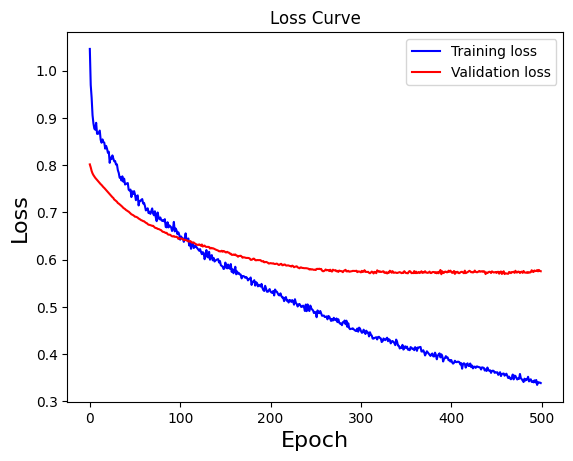

fold1.npy:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 12/13
Epoch 0 --- loss:0.398, Epoch accuracy:51.61%, Validation loss:0.316, Validation accuracy:58.00%
Epoch 1: iteration 12/13
Epoch 1 --- loss:0.409, Epoch accuracy:50.47%, Validation loss:0.326, Validation accuracy:56.33%
Epoch 2: iteration 12/13
Epoch 2 --- loss:0.394, Epoch accuracy:51.55%, Validation loss:0.325, Validation accuracy:56.22%
Epoch 3: iteration 12/13
Epoch 3 --- loss:0.396, Epoch accuracy:51.70%, Validation loss:0.325, Validation accuracy:56.22%
Epoch 4: iteration 12/13
Epoch 4 --- loss:0.390, Epoch accuracy:52.43%, Validation loss:0.326, Validation accuracy:56.33%
Epoch 5: iteration 12/13
Epoch 5 --- loss:0.389, Epoch accuracy:51.96%, Validation loss:0.329, Validation accuracy:56.11%
Epoch 6: iteration 12/13
Epoch 6 --- loss:0.383, Epoch accuracy:52.11%, Validation loss:0.329, Validation accuracy:55.89%
Epoch 7: iteration 12/13
Epoch 7 --- loss:0.389, Epoch accuracy:52.84%, Validation loss:0.329, Validation accuracy:56.00%
Epoch 8: iteration 12/13

Epoch 67: iteration 12/13
Epoch 67 --- loss:0.352, Epoch accuracy:56.05%, Validation loss:0.347, Validation accuracy:54.78%
Epoch 68: iteration 12/13
Epoch 68 --- loss:0.353, Epoch accuracy:54.80%, Validation loss:0.347, Validation accuracy:54.78%
Epoch 69: iteration 12/13
Epoch 69 --- loss:0.350, Epoch accuracy:55.41%, Validation loss:0.348, Validation accuracy:54.56%
Epoch 70: iteration 12/13
Epoch 70 --- loss:0.359, Epoch accuracy:53.92%, Validation loss:0.348, Validation accuracy:54.56%
Epoch 71: iteration 12/13
Epoch 71 --- loss:0.351, Epoch accuracy:55.44%, Validation loss:0.349, Validation accuracy:54.33%
Epoch 72: iteration 12/13
Epoch 72 --- loss:0.356, Epoch accuracy:55.15%, Validation loss:0.349, Validation accuracy:54.22%
Epoch 73: iteration 12/13
Epoch 73 --- loss:0.350, Epoch accuracy:55.00%, Validation loss:0.348, Validation accuracy:54.44%
Epoch 74: iteration 12/13
Epoch 74 --- loss:0.351, Epoch accuracy:54.88%, Validation loss:0.347, Validation accuracy:55.11%
Epoch 75

Epoch 133: iteration 12/13
Epoch 133 --- loss:0.326, Epoch accuracy:57.98%, Validation loss:0.356, Validation accuracy:54.44%
Epoch 134: iteration 12/13
Epoch 134 --- loss:0.326, Epoch accuracy:57.16%, Validation loss:0.356, Validation accuracy:54.00%
Epoch 135: iteration 12/13
Epoch 135 --- loss:0.328, Epoch accuracy:57.75%, Validation loss:0.355, Validation accuracy:54.56%
Epoch 136: iteration 12/13
Epoch 136 --- loss:0.328, Epoch accuracy:57.08%, Validation loss:0.354, Validation accuracy:54.44%
Epoch 137: iteration 12/13
Epoch 137 --- loss:0.325, Epoch accuracy:58.22%, Validation loss:0.356, Validation accuracy:54.00%
Epoch 138: iteration 12/13
Epoch 138 --- loss:0.326, Epoch accuracy:57.08%, Validation loss:0.354, Validation accuracy:54.22%
Epoch 139: iteration 12/13
Epoch 139 --- loss:0.327, Epoch accuracy:58.19%, Validation loss:0.356, Validation accuracy:54.44%
Epoch 140: iteration 12/13
Epoch 140 --- loss:0.326, Epoch accuracy:57.49%, Validation loss:0.356, Validation accuracy

Epoch 263: iteration 12/13
Epoch 263 --- loss:0.287, Epoch accuracy:60.50%, Validation loss:0.373, Validation accuracy:53.33%
Epoch 264: iteration 12/13
Epoch 264 --- loss:0.284, Epoch accuracy:61.11%, Validation loss:0.370, Validation accuracy:54.00%
Epoch 265: iteration 12/13
Epoch 265 --- loss:0.282, Epoch accuracy:61.61%, Validation loss:0.370, Validation accuracy:54.00%
Epoch 266: iteration 12/13
Epoch 266 --- loss:0.288, Epoch accuracy:60.58%, Validation loss:0.371, Validation accuracy:53.33%
Epoch 267: iteration 12/13
Epoch 267 --- loss:0.284, Epoch accuracy:61.29%, Validation loss:0.373, Validation accuracy:53.00%
Epoch 268: iteration 12/13
Epoch 268 --- loss:0.283, Epoch accuracy:60.94%, Validation loss:0.370, Validation accuracy:54.00%
Epoch 269: iteration 12/13
Epoch 269 --- loss:0.279, Epoch accuracy:62.43%, Validation loss:0.371, Validation accuracy:53.89%
Epoch 270: iteration 12/13
Epoch 270 --- loss:0.284, Epoch accuracy:61.11%, Validation loss:0.373, Validation accuracy

Epoch 393: iteration 12/13
Epoch 393 --- loss:0.246, Epoch accuracy:65.76%, Validation loss:0.387, Validation accuracy:53.22%
Epoch 394: iteration 12/13
Epoch 394 --- loss:0.253, Epoch accuracy:63.16%, Validation loss:0.386, Validation accuracy:53.22%
Epoch 395: iteration 12/13
Epoch 395 --- loss:0.251, Epoch accuracy:64.88%, Validation loss:0.388, Validation accuracy:52.44%
Epoch 396: iteration 12/13
Epoch 396 --- loss:0.249, Epoch accuracy:65.23%, Validation loss:0.385, Validation accuracy:53.11%
Epoch 397: iteration 12/13
Epoch 397 --- loss:0.250, Epoch accuracy:64.21%, Validation loss:0.385, Validation accuracy:53.44%
Epoch 398: iteration 12/13
Epoch 398 --- loss:0.248, Epoch accuracy:65.26%, Validation loss:0.387, Validation accuracy:52.78%
Epoch 399: iteration 12/13
Epoch 399 --- loss:0.250, Epoch accuracy:65.00%, Validation loss:0.388, Validation accuracy:53.56%
Epoch 400: iteration 12/13
Epoch 400 --- loss:0.253, Epoch accuracy:65.12%, Validation loss:0.387, Validation accuracy

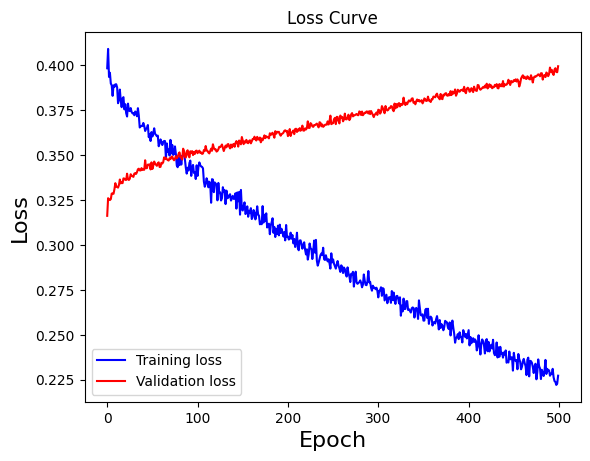

fold2.npy:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 12/13
Epoch 0 --- loss:0.276, Epoch accuracy:62.05%, Validation loss:0.249, Validation accuracy:67.00%
Epoch 1: iteration 12/13
Epoch 1 --- loss:0.279, Epoch accuracy:61.73%, Validation loss:0.246, Validation accuracy:67.44%
Epoch 2: iteration 12/13
Epoch 2 --- loss:0.268, Epoch accuracy:62.40%, Validation loss:0.245, Validation accuracy:67.89%
Epoch 3: iteration 12/13
Epoch 3 --- loss:0.269, Epoch accuracy:62.37%, Validation loss:0.245, Validation accuracy:67.22%
Epoch 4: iteration 12/13
Epoch 4 --- loss:0.268, Epoch accuracy:61.75%, Validation loss:0.250, Validation accuracy:66.89%
Epoch 5: iteration 12/13
Epoch 5 --- loss:0.267, Epoch accuracy:62.25%, Validation loss:0.252, Validation accuracy:66.33%
Epoch 6: iteration 12/13
Epoch 6 --- loss:0.270, Epoch accuracy:62.46%, Validation loss:0.249, Validation accuracy:66.78%
Epoch 7: iteration 12/13
Epoch 7 --- loss:0.261, Epoch accuracy:62.95%, Validation loss:0.249, Validation accuracy:66.67%
Epoch 8: iteration 12/13

Epoch 67: iteration 12/13
Epoch 67 --- loss:0.232, Epoch accuracy:64.77%, Validation loss:0.277, Validation accuracy:65.33%
Epoch 68: iteration 12/13
Epoch 68 --- loss:0.238, Epoch accuracy:65.23%, Validation loss:0.279, Validation accuracy:65.44%
Epoch 69: iteration 12/13
Epoch 69 --- loss:0.227, Epoch accuracy:65.76%, Validation loss:0.280, Validation accuracy:65.22%
Epoch 70: iteration 12/13
Epoch 70 --- loss:0.236, Epoch accuracy:64.85%, Validation loss:0.281, Validation accuracy:65.22%
Epoch 71: iteration 12/13
Epoch 71 --- loss:0.234, Epoch accuracy:65.94%, Validation loss:0.279, Validation accuracy:65.00%
Epoch 72: iteration 12/13
Epoch 72 --- loss:0.232, Epoch accuracy:65.50%, Validation loss:0.280, Validation accuracy:64.78%
Epoch 73: iteration 12/13
Epoch 73 --- loss:0.229, Epoch accuracy:66.61%, Validation loss:0.277, Validation accuracy:65.00%
Epoch 74: iteration 12/13
Epoch 74 --- loss:0.230, Epoch accuracy:66.26%, Validation loss:0.279, Validation accuracy:64.56%
Epoch 75

Epoch 133: iteration 12/13
Epoch 133 --- loss:0.220, Epoch accuracy:66.46%, Validation loss:0.291, Validation accuracy:64.33%
Epoch 134: iteration 12/13
Epoch 134 --- loss:0.215, Epoch accuracy:67.16%, Validation loss:0.290, Validation accuracy:65.11%
Epoch 135: iteration 12/13
Epoch 135 --- loss:0.219, Epoch accuracy:67.43%, Validation loss:0.291, Validation accuracy:64.89%
Epoch 136: iteration 12/13
Epoch 136 --- loss:0.213, Epoch accuracy:66.29%, Validation loss:0.290, Validation accuracy:64.78%
Epoch 137: iteration 12/13
Epoch 137 --- loss:0.218, Epoch accuracy:66.96%, Validation loss:0.290, Validation accuracy:64.67%
Epoch 138: iteration 12/13
Epoch 138 --- loss:0.217, Epoch accuracy:67.31%, Validation loss:0.289, Validation accuracy:64.78%
Epoch 139: iteration 12/13
Epoch 139 --- loss:0.215, Epoch accuracy:67.25%, Validation loss:0.292, Validation accuracy:64.44%
Epoch 140: iteration 12/13
Epoch 140 --- loss:0.215, Epoch accuracy:67.66%, Validation loss:0.293, Validation accuracy

Epoch 263: iteration 12/13
Epoch 263 --- loss:0.190, Epoch accuracy:70.73%, Validation loss:0.307, Validation accuracy:63.89%
Epoch 264: iteration 12/13
Epoch 264 --- loss:0.187, Epoch accuracy:70.32%, Validation loss:0.307, Validation accuracy:64.00%
Epoch 265: iteration 12/13
Epoch 265 --- loss:0.190, Epoch accuracy:70.38%, Validation loss:0.308, Validation accuracy:64.11%
Epoch 266: iteration 12/13
Epoch 266 --- loss:0.187, Epoch accuracy:69.97%, Validation loss:0.308, Validation accuracy:63.56%
Epoch 267: iteration 12/13
Epoch 267 --- loss:0.187, Epoch accuracy:70.41%, Validation loss:0.306, Validation accuracy:63.44%
Epoch 268: iteration 12/13
Epoch 268 --- loss:0.187, Epoch accuracy:70.99%, Validation loss:0.309, Validation accuracy:64.00%
Epoch 269: iteration 12/13
Epoch 269 --- loss:0.186, Epoch accuracy:69.53%, Validation loss:0.306, Validation accuracy:63.78%
Epoch 270: iteration 12/13
Epoch 270 --- loss:0.185, Epoch accuracy:69.91%, Validation loss:0.306, Validation accuracy

Epoch 393: iteration 12/13
Epoch 393 --- loss:0.164, Epoch accuracy:73.25%, Validation loss:0.322, Validation accuracy:63.67%
Epoch 394: iteration 12/13
Epoch 394 --- loss:0.168, Epoch accuracy:72.05%, Validation loss:0.324, Validation accuracy:63.22%
Epoch 395: iteration 12/13
Epoch 395 --- loss:0.167, Epoch accuracy:72.78%, Validation loss:0.323, Validation accuracy:62.89%
Epoch 396: iteration 12/13
Epoch 396 --- loss:0.167, Epoch accuracy:73.54%, Validation loss:0.320, Validation accuracy:63.33%
Epoch 397: iteration 12/13
Epoch 397 --- loss:0.166, Epoch accuracy:71.90%, Validation loss:0.324, Validation accuracy:63.11%
Epoch 398: iteration 12/13
Epoch 398 --- loss:0.165, Epoch accuracy:72.95%, Validation loss:0.324, Validation accuracy:63.67%
Epoch 399: iteration 12/13
Epoch 399 --- loss:0.166, Epoch accuracy:72.49%, Validation loss:0.324, Validation accuracy:63.22%
Epoch 400: iteration 12/13
Epoch 400 --- loss:0.162, Epoch accuracy:73.36%, Validation loss:0.323, Validation accuracy

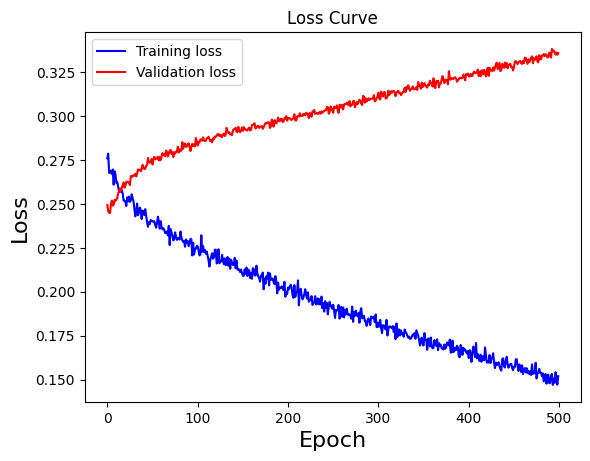

fold3.npy:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 12/13
Epoch 0 --- loss:0.216, Epoch accuracy:67.51%, Validation loss:0.128, Validation accuracy:80.89%
Epoch 1: iteration 12/13
Epoch 1 --- loss:0.219, Epoch accuracy:67.89%, Validation loss:0.128, Validation accuracy:80.56%
Epoch 2: iteration 12/13
Epoch 2 --- loss:0.214, Epoch accuracy:68.36%, Validation loss:0.128, Validation accuracy:80.44%
Epoch 3: iteration 12/13
Epoch 3 --- loss:0.212, Epoch accuracy:67.98%, Validation loss:0.127, Validation accuracy:80.33%
Epoch 4: iteration 12/13
Epoch 4 --- loss:0.212, Epoch accuracy:67.95%, Validation loss:0.127, Validation accuracy:80.89%
Epoch 5: iteration 12/13
Epoch 5 --- loss:0.206, Epoch accuracy:69.15%, Validation loss:0.128, Validation accuracy:80.56%
Epoch 6: iteration 12/13
Epoch 6 --- loss:0.203, Epoch accuracy:68.71%, Validation loss:0.133, Validation accuracy:80.00%
Epoch 7: iteration 12/13
Epoch 7 --- loss:0.211, Epoch accuracy:67.40%, Validation loss:0.131, Validation accuracy:80.11%
Epoch 8: iteration 12/13

Epoch 67: iteration 12/13
Epoch 67 --- loss:0.189, Epoch accuracy:70.23%, Validation loss:0.145, Validation accuracy:79.89%
Epoch 68: iteration 12/13
Epoch 68 --- loss:0.185, Epoch accuracy:70.82%, Validation loss:0.143, Validation accuracy:80.00%
Epoch 69: iteration 12/13
Epoch 69 --- loss:0.184, Epoch accuracy:71.11%, Validation loss:0.143, Validation accuracy:79.78%
Epoch 70: iteration 12/13
Epoch 70 --- loss:0.182, Epoch accuracy:71.32%, Validation loss:0.145, Validation accuracy:79.78%
Epoch 71: iteration 12/13
Epoch 71 --- loss:0.185, Epoch accuracy:71.26%, Validation loss:0.145, Validation accuracy:79.11%
Epoch 72: iteration 12/13
Epoch 72 --- loss:0.181, Epoch accuracy:72.34%, Validation loss:0.144, Validation accuracy:79.44%
Epoch 73: iteration 12/13
Epoch 73 --- loss:0.189, Epoch accuracy:70.61%, Validation loss:0.145, Validation accuracy:79.44%
Epoch 74: iteration 12/13
Epoch 74 --- loss:0.184, Epoch accuracy:71.40%, Validation loss:0.144, Validation accuracy:79.33%
Epoch 75

Epoch 133: iteration 12/13
Epoch 133 --- loss:0.171, Epoch accuracy:72.75%, Validation loss:0.153, Validation accuracy:78.44%
Epoch 134: iteration 12/13
Epoch 134 --- loss:0.173, Epoch accuracy:72.46%, Validation loss:0.152, Validation accuracy:78.22%
Epoch 135: iteration 12/13
Epoch 135 --- loss:0.170, Epoch accuracy:73.10%, Validation loss:0.153, Validation accuracy:78.67%
Epoch 136: iteration 12/13
Epoch 136 --- loss:0.172, Epoch accuracy:72.84%, Validation loss:0.154, Validation accuracy:78.33%
Epoch 137: iteration 12/13
Epoch 137 --- loss:0.172, Epoch accuracy:72.31%, Validation loss:0.153, Validation accuracy:78.56%
Epoch 138: iteration 12/13
Epoch 138 --- loss:0.170, Epoch accuracy:71.99%, Validation loss:0.155, Validation accuracy:78.67%
Epoch 139: iteration 12/13
Epoch 139 --- loss:0.168, Epoch accuracy:72.25%, Validation loss:0.154, Validation accuracy:78.33%
Epoch 140: iteration 12/13
Epoch 140 --- loss:0.167, Epoch accuracy:73.19%, Validation loss:0.155, Validation accuracy

Epoch 263: iteration 12/13
Epoch 263 --- loss:0.149, Epoch accuracy:74.97%, Validation loss:0.170, Validation accuracy:76.89%
Epoch 264: iteration 12/13
Epoch 264 --- loss:0.149, Epoch accuracy:73.80%, Validation loss:0.168, Validation accuracy:76.67%
Epoch 265: iteration 12/13
Epoch 265 --- loss:0.152, Epoch accuracy:74.62%, Validation loss:0.170, Validation accuracy:76.22%
Epoch 266: iteration 12/13
Epoch 266 --- loss:0.153, Epoch accuracy:74.82%, Validation loss:0.172, Validation accuracy:76.67%
Epoch 267: iteration 12/13
Epoch 267 --- loss:0.150, Epoch accuracy:75.35%, Validation loss:0.171, Validation accuracy:77.11%
Epoch 268: iteration 12/13
Epoch 268 --- loss:0.150, Epoch accuracy:75.03%, Validation loss:0.170, Validation accuracy:76.78%
Epoch 269: iteration 12/13
Epoch 269 --- loss:0.147, Epoch accuracy:75.96%, Validation loss:0.171, Validation accuracy:76.89%
Epoch 270: iteration 12/13
Epoch 270 --- loss:0.155, Epoch accuracy:74.56%, Validation loss:0.169, Validation accuracy

Epoch 393: iteration 12/13
Epoch 393 --- loss:0.136, Epoch accuracy:76.58%, Validation loss:0.183, Validation accuracy:75.56%
Epoch 394: iteration 12/13
Epoch 394 --- loss:0.132, Epoch accuracy:77.28%, Validation loss:0.185, Validation accuracy:75.67%
Epoch 395: iteration 12/13
Epoch 395 --- loss:0.134, Epoch accuracy:76.84%, Validation loss:0.185, Validation accuracy:76.11%
Epoch 396: iteration 12/13
Epoch 396 --- loss:0.134, Epoch accuracy:77.31%, Validation loss:0.184, Validation accuracy:75.67%
Epoch 397: iteration 12/13
Epoch 397 --- loss:0.137, Epoch accuracy:77.13%, Validation loss:0.183, Validation accuracy:75.56%
Epoch 398: iteration 12/13
Epoch 398 --- loss:0.137, Epoch accuracy:77.08%, Validation loss:0.183, Validation accuracy:75.78%
Epoch 399: iteration 12/13
Epoch 399 --- loss:0.134, Epoch accuracy:76.99%, Validation loss:0.187, Validation accuracy:75.78%
Epoch 400: iteration 12/13
Epoch 400 --- loss:0.131, Epoch accuracy:77.13%, Validation loss:0.186, Validation accuracy

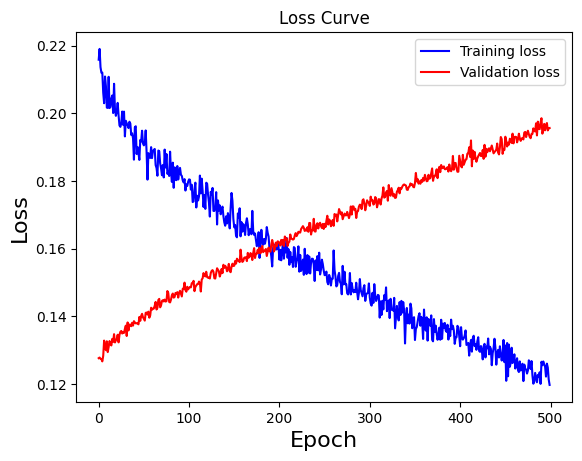

fold4.npy:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: iteration 13/14
Epoch 0 --- loss:0.155, Epoch accuracy:76.17%, Validation loss:0.125, Validation accuracy:80.42%
Epoch 1: iteration 13/14
Epoch 1 --- loss:0.158, Epoch accuracy:76.83%, Validation loss:0.125, Validation accuracy:81.25%
Epoch 2: iteration 13/14
Epoch 2 --- loss:0.155, Epoch accuracy:76.50%, Validation loss:0.128, Validation accuracy:81.53%
Epoch 3: iteration 13/14
Epoch 3 --- loss:0.156, Epoch accuracy:76.50%, Validation loss:0.131, Validation accuracy:79.86%
Epoch 4: iteration 13/14
Epoch 4 --- loss:0.155, Epoch accuracy:76.83%, Validation loss:0.132, Validation accuracy:80.56%
Epoch 5: iteration 13/14
Epoch 5 --- loss:0.151, Epoch accuracy:76.92%, Validation loss:0.130, Validation accuracy:80.69%
Epoch 6: iteration 13/14
Epoch 6 --- loss:0.153, Epoch accuracy:77.06%, Validation loss:0.132, Validation accuracy:80.56%
Epoch 7: iteration 13/14
Epoch 7 --- loss:0.150, Epoch accuracy:76.83%, Validation loss:0.135, Validation accuracy:80.14%
Epoch 8: iteration 13/14

Epoch 67: iteration 13/14
Epoch 67 --- loss:0.131, Epoch accuracy:79.67%, Validation loss:0.176, Validation accuracy:76.25%
Epoch 68: iteration 13/14
Epoch 68 --- loss:0.129, Epoch accuracy:79.67%, Validation loss:0.177, Validation accuracy:76.39%
Epoch 69: iteration 13/14
Epoch 69 --- loss:0.129, Epoch accuracy:79.44%, Validation loss:0.176, Validation accuracy:76.11%
Epoch 70: iteration 13/14
Epoch 70 --- loss:0.130, Epoch accuracy:79.33%, Validation loss:0.178, Validation accuracy:76.11%
Epoch 71: iteration 13/14
Epoch 71 --- loss:0.129, Epoch accuracy:79.42%, Validation loss:0.175, Validation accuracy:76.25%
Epoch 72: iteration 13/14
Epoch 72 --- loss:0.130, Epoch accuracy:79.75%, Validation loss:0.176, Validation accuracy:76.11%
Epoch 73: iteration 13/14
Epoch 73 --- loss:0.128, Epoch accuracy:80.08%, Validation loss:0.178, Validation accuracy:76.11%
Epoch 74: iteration 13/14
Epoch 74 --- loss:0.132, Epoch accuracy:79.89%, Validation loss:0.180, Validation accuracy:75.97%
Epoch 75

Epoch 133: iteration 13/14
Epoch 133 --- loss:0.119, Epoch accuracy:80.22%, Validation loss:0.197, Validation accuracy:74.44%
Epoch 134: iteration 13/14
Epoch 134 --- loss:0.118, Epoch accuracy:80.83%, Validation loss:0.196, Validation accuracy:73.75%
Epoch 135: iteration 13/14
Epoch 135 --- loss:0.121, Epoch accuracy:80.08%, Validation loss:0.198, Validation accuracy:74.03%
Epoch 136: iteration 13/14
Epoch 136 --- loss:0.120, Epoch accuracy:80.58%, Validation loss:0.198, Validation accuracy:74.03%
Epoch 137: iteration 13/14
Epoch 137 --- loss:0.116, Epoch accuracy:82.14%, Validation loss:0.196, Validation accuracy:74.86%
Epoch 138: iteration 13/14
Epoch 138 --- loss:0.121, Epoch accuracy:80.22%, Validation loss:0.199, Validation accuracy:73.47%
Epoch 139: iteration 13/14
Epoch 139 --- loss:0.121, Epoch accuracy:80.75%, Validation loss:0.200, Validation accuracy:73.06%
Epoch 140: iteration 13/14
Epoch 140 --- loss:0.117, Epoch accuracy:81.31%, Validation loss:0.199, Validation accuracy

Epoch 263: iteration 13/14
Epoch 263 --- loss:0.107, Epoch accuracy:82.36%, Validation loss:0.232, Validation accuracy:70.56%
Epoch 264: iteration 13/14
Epoch 264 --- loss:0.104, Epoch accuracy:82.89%, Validation loss:0.233, Validation accuracy:70.28%
Epoch 265: iteration 13/14
Epoch 265 --- loss:0.108, Epoch accuracy:81.75%, Validation loss:0.234, Validation accuracy:70.28%
Epoch 266: iteration 13/14
Epoch 266 --- loss:0.106, Epoch accuracy:82.28%, Validation loss:0.233, Validation accuracy:70.83%
Epoch 267: iteration 13/14
Epoch 267 --- loss:0.107, Epoch accuracy:81.75%, Validation loss:0.236, Validation accuracy:70.83%
Epoch 268: iteration 13/14
Epoch 268 --- loss:0.106, Epoch accuracy:82.47%, Validation loss:0.233, Validation accuracy:71.39%
Epoch 269: iteration 13/14
Epoch 269 --- loss:0.108, Epoch accuracy:82.08%, Validation loss:0.240, Validation accuracy:70.14%
Epoch 270: iteration 13/14
Epoch 270 --- loss:0.104, Epoch accuracy:82.78%, Validation loss:0.238, Validation accuracy

Epoch 393: iteration 13/14
Epoch 393 --- loss:0.094, Epoch accuracy:84.00%, Validation loss:0.268, Validation accuracy:68.06%
Epoch 394: iteration 13/14
Epoch 394 --- loss:0.094, Epoch accuracy:84.61%, Validation loss:0.266, Validation accuracy:68.19%
Epoch 395: iteration 13/14
Epoch 395 --- loss:0.092, Epoch accuracy:84.00%, Validation loss:0.267, Validation accuracy:68.19%
Epoch 396: iteration 13/14
Epoch 396 --- loss:0.092, Epoch accuracy:83.83%, Validation loss:0.265, Validation accuracy:68.19%
Epoch 397: iteration 13/14
Epoch 397 --- loss:0.095, Epoch accuracy:84.22%, Validation loss:0.267, Validation accuracy:67.92%
Epoch 398: iteration 13/14
Epoch 398 --- loss:0.089, Epoch accuracy:84.94%, Validation loss:0.271, Validation accuracy:67.78%
Epoch 399: iteration 13/14
Epoch 399 --- loss:0.092, Epoch accuracy:84.39%, Validation loss:0.274, Validation accuracy:67.64%
Epoch 400: iteration 13/14
Epoch 400 --- loss:0.089, Epoch accuracy:84.33%, Validation loss:0.266, Validation accuracy

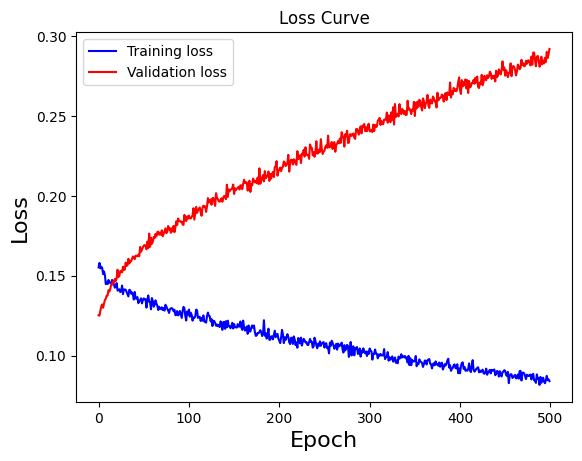

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

npy_path = './npy'
all_npy = os.listdir(npy_path)

test_accs = []
train_losses, valid_losses = [], []

print(f'[*] model training - {sub_name}')
for fold in all_npy:
    npy = os.path.join(npy_path, fold)
    
    with open(npy, 'rb') as f:
        X_train = np.load(f)
        X_test = np.load(f)
        y_train = np.load(f)
        y_test = np.load(f)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    train_losses, valid_losses = train(model, num_epochs, X_train, y_train, X_test, y_test, pkl_name, fold)
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(train_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()

./npy\fold0.npy
[*] fold0.npy Test accuracy is 41.33%


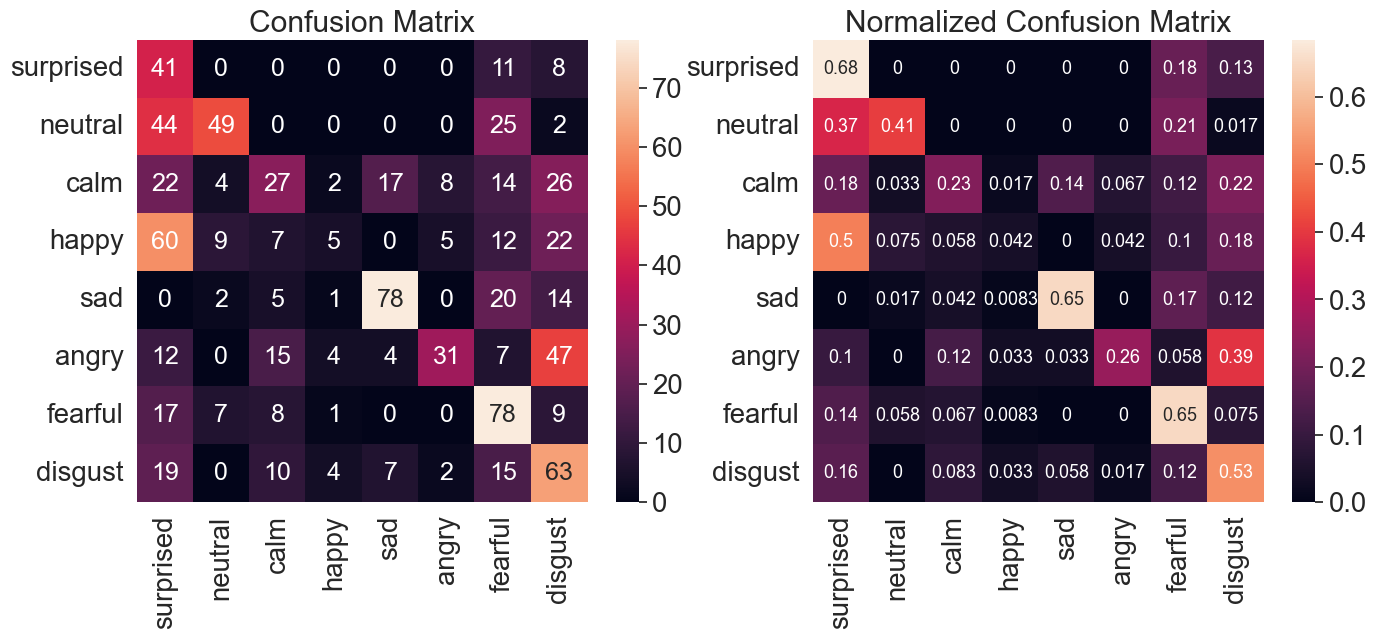

./npy\fold1.npy
[*] fold1.npy Test accuracy is 58.00%


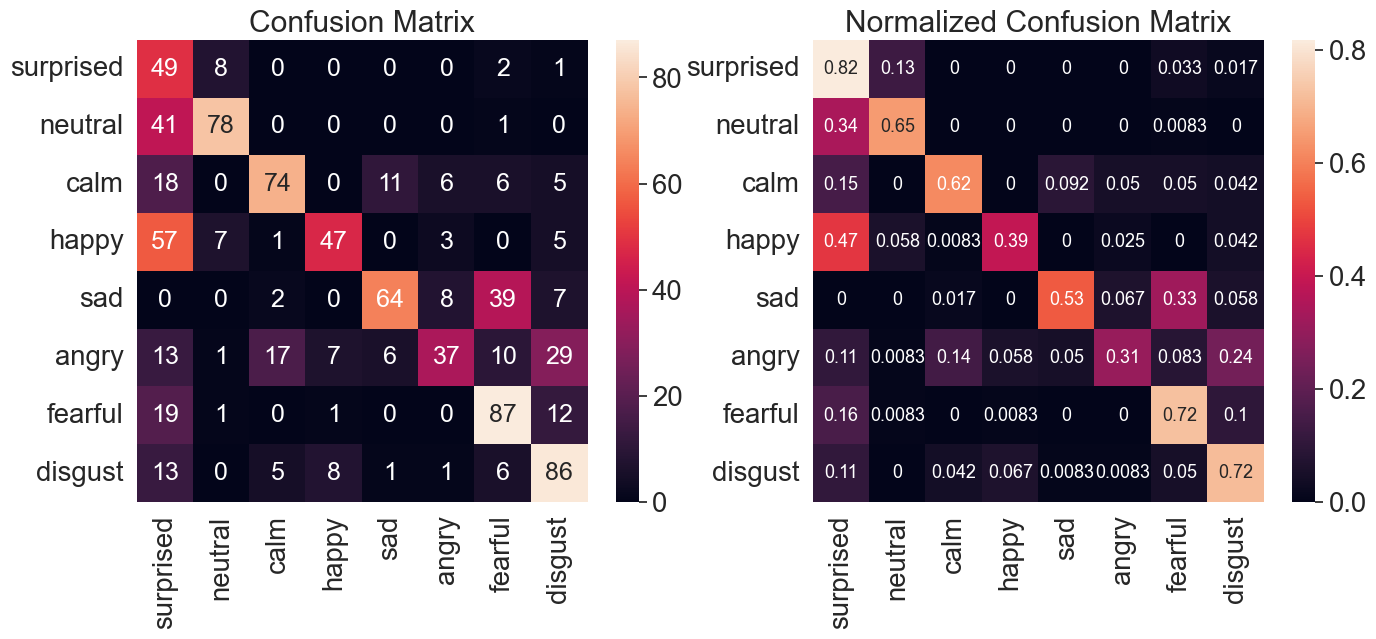

./npy\fold2.npy
[*] fold2.npy Test accuracy is 67.22%


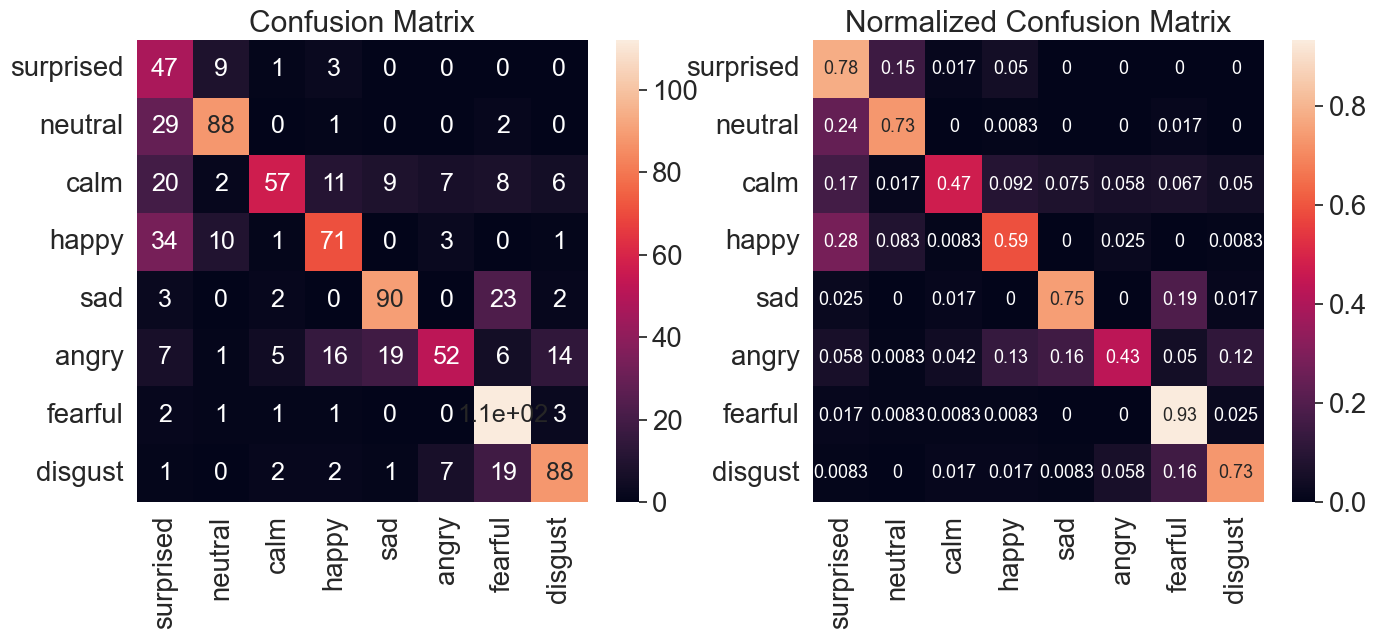

./npy\fold3.npy
[*] fold3.npy Test accuracy is 80.89%


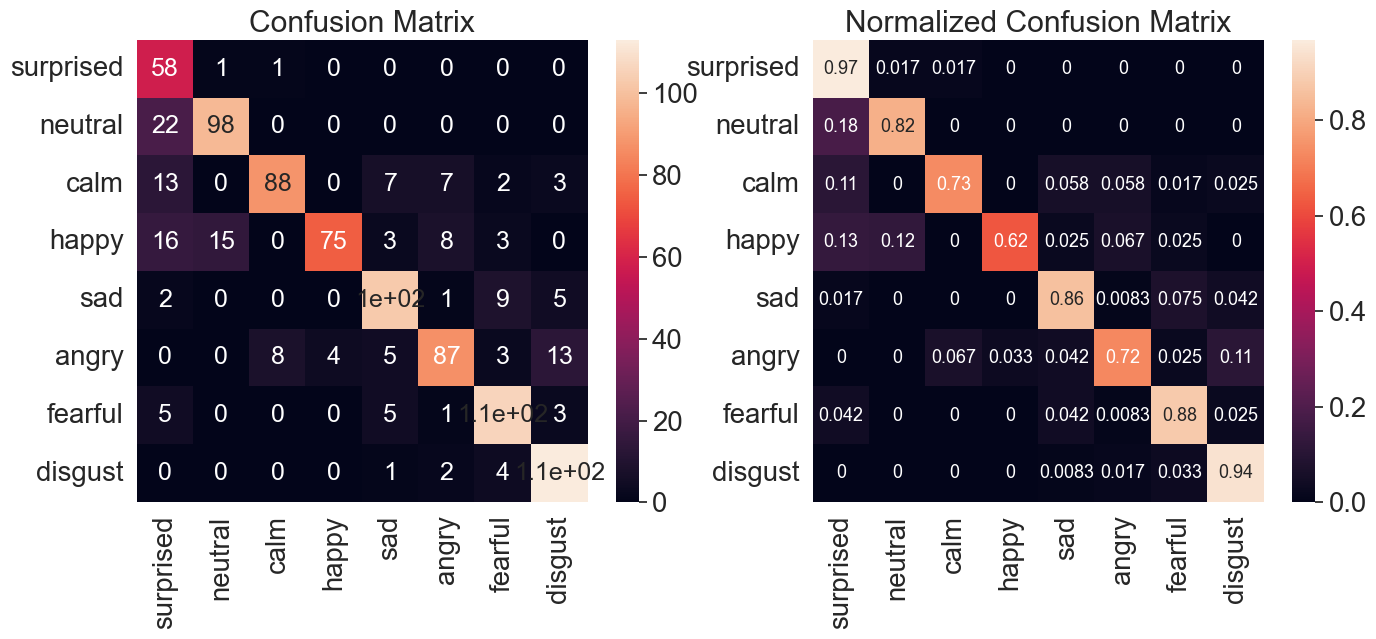

./npy\fold4.npy
[*] fold4.npy Test accuracy is 81.39%


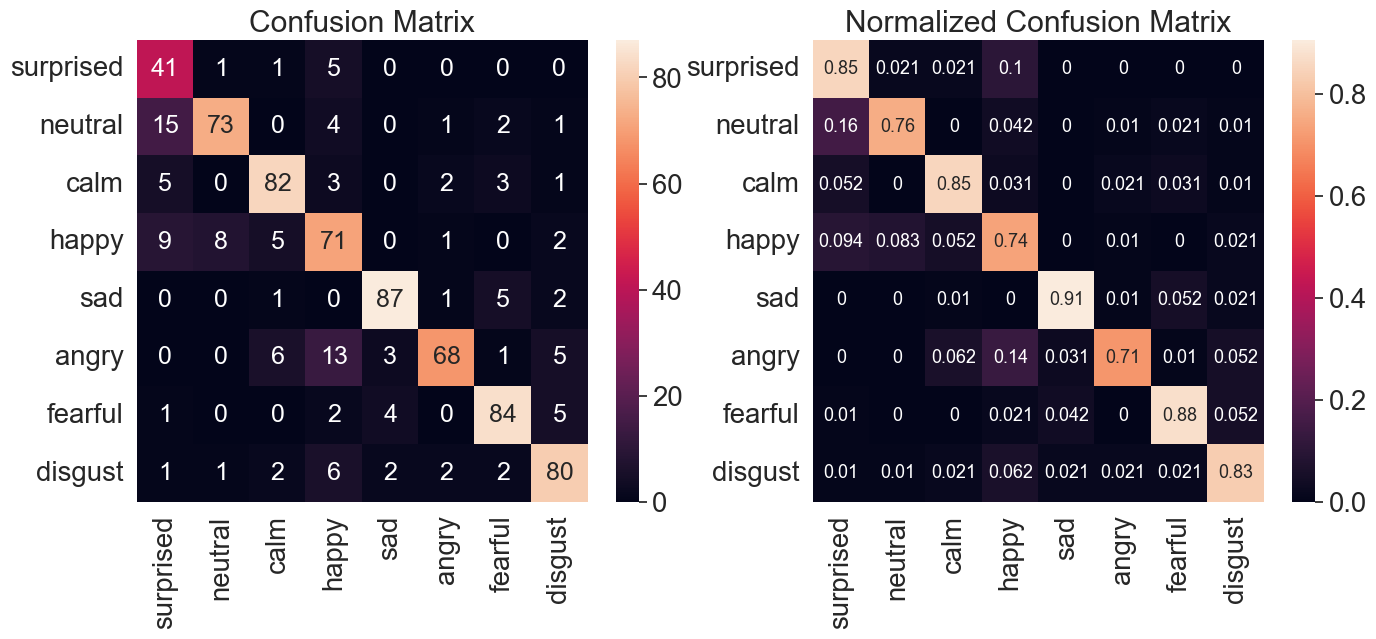

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

npy_path = './npy'
all_npy = os.listdir(npy_path)

model = parallel_all_you_want(num_emotions=len(emotions_dict))

test_accs = []


for fold in all_npy:
    npy = os.path.join(npy_path, fold)
    
    with open(npy, 'rb') as f:
        X_train = np.load(f)
        X_test = np.load(f)
        y_train = np.load(f)
        y_test = np.load(f)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    print(npy)
    
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    print(f'[*] {fold} Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test

    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = [emotion for emotion in emotions_dict.values()]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()

In [12]:
def Average(lst):
    return sum(lst) / len(lst)

print('[*] K-Fold training done !')
print(f'[*] Best fold acc : {max(test_accs):.2f}%')
print(f'[*] Worst fold acc : {min(test_accs):.2f}%')
print(f'[*] Average fold acc : {Average(test_accs):.2f}%')

[*] K-Fold training done !
[*] Best fold acc : 81.39%
[*] Worst fold acc : 41.33%
[*] Average fold acc : 65.77%
